# Module Four Final Project

For: Trace Political, LLC

By: Jonathan E. Ericksen, JE Consulting

## Background
> Trace Political is a consulting firm that specializes in social media consulting for congressional campaigns. Trace Political has contracted with JE Consulting to run analysis on ~86K tweets from sitting congressional representatives. The tweets were acquired from May 2018 and are expected to yield valuable insights into the social media behavior and trends from current elected officials. 

## Objective:
> The objective for JE consulting is two fold: 
- **Objective One: Corpus Analysis**
    - Analyze the common words used within tweets from both Democrat and Republican representatives
    - Extract words used in relation to the following through word vectorization: 
        - Trump
        - Bill
        - Taxes (and tax)
        - Party
        - Republican(s)
        - Democrat(s)
        - Lie
        - Congress
    - Using TextBlob, extract the sentiment rating for Democrat and Republican tweets

>- **Objective Two: Tweet Classification with Neural Networks**
    - In addition to corpus analysis, Trace Political has asked JE Consulting to suss out the feasibility of building a classifier using a neural network that successfully predicts the political party of which the author of an official tweet belongs. In order to be deemed successful, the model must successfully predict political party with 90% accuracy on test data. Should this succeed, Trace Political will further pursue projects related to predictive modeling with natural language processing within the social media realm. 

## Question:
> *** Beyond the questions posed in part one of the "Objective" outline above, Trace Political is interested if successfully producing a text classification network using natural language processing. Thus, the resulting question is as follows: Can a model be successfully classify political affiliation based on language contained in official tweets?

## Methodology:

> This project loosely follows the industry standard OSEMiN process. The 5 stages in OSEMiN are outlined in the table of contents below with each stage highlighted within the ensuing notebook.

## Table of Contents:<a id='top'></a>
> #### [Obtain](#obtain): 
- Sourcing the data
- Importing data

> #### [Explore](#explore): 
- Data preprocessing, cleaning & wrangling
- Tokenization

> #### [Feature Engineering](#condition):
- xx

> #### [Model](#model):
- Initial Model
- Initial Model Interpretation & Notes
- Data Rebalancing
- Feature engineering
- Hyperparameter tuning
- Initial Cost Benefit analysis
- Model iterations
- Final model

> *(non-OSEMiN additions)*
- **[Cost Benefit Analysis](#costbenefitanalysis)**
- **[Conclusions](#conclusion)**
    - Answer to our business question
- **[Recommendations](#recommendation)**
- **[Future Work](#futurework)**

------------------------------------------------------------------------------------------------------------------

Before we begin, let's import the necessary libraries for our project: 

In [2]:
import pandas as pd

import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros

import string

import re
import nltk as nlp
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.probability import FreqDist
nlp.download('wordnet')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, LSTM, GRU
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, GRU, Dense, GlobalMaxPool1D, Embedding, Dropout
from keras.preprocessing import text, sequence
from sklearn.preprocessing import OneHotEncoder

import gensim
from gensim.models import Word2Vec

from textblob import TextBlob

from sklearn.model_selection import train_test_split

import warnings; warnings.simplefilter('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jonathanericksen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Using TensorFlow backend.


## Obtain <a id='obtain'></a>

[Back to top](#top)

The data used for this project comes from Kaggle and includes a sampling of ~86k tweets sent from both Democratic and Republican representatives in the U.S. congress during May 2018. The dataset can be found here: https://www.kaggle.com/kapastor/democratvsrepublicantweets 

Let's lod the CSV file from kaggle into a pandas dataframe: 

In [31]:
df = pd.read_csv('ExtractedTweets.csv')

------------------------------------------------------------------------------------------------------------------
## Explatory Data Analysis <a id='explore'></a>

[Back to top](#top)

We'll begin our exploratory analysis by reviewing the head and tail of the dataset:

In [32]:
display(df.head())
display(df.tail())

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


,Party,Handle,Tweet
86455,Republican,RepTomPrice,Check out my op-ed on need for End Executive O...
86456,Republican,RepTomPrice,"Yesterday, Betty &amp; I had a great time lear..."
86457,Republican,RepTomPrice,We are forever grateful for the service and sa...
86458,Republican,RepTomPrice,Happy first day of school @CobbSchools! #CobbB...
86459,Republican,RepTomPrice,#Zika fears realized in Florida. House GOP act...


Let's confirm there are no null values:

In [33]:
display(df.isnull().sum())

Party     0
Handle    0
Tweet     0
dtype: int64

Check the shape of the dataset:

In [34]:
df.shape

(86460, 3)

And look at the first 5 full tweets: 

In [86]:
display(df['Tweet'][0])
display(df['Tweet'][1])
display(df['Tweet'][2])
display(df['Tweet'][3])
display(df['Tweet'][4])

'Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House… https://t.co/n3tggDLU1L'

'RT @WinterHavenSun: Winter Haven resident / Alta Vista teacher is one of several recognized by @RepDarrenSoto for National Teacher Apprecia…'

'RT @NBCLatino: .@RepDarrenSoto noted that Hurricane Maria has left approximately $90 billion in damages. \n\nCongress has allocated about $18…'

'RT @NALCABPolicy: Meeting with @RepDarrenSoto . Thanks for taking the time to meet with @LatinoLeader ED Marucci Guzman. #NALCABPolicy2018.…'

'RT @Vegalteno: Hurricane season starts on June 1st; Puerto Rico’s readiness...well 🤦🏼\u200d♂️😡😩@Pwr4PuertoRico @RepDarrenSoto @EspaillatNY'

**Number of Tweets by Party**

Next we'll separate out the tweets along party lines for further analysis:

In [87]:
democrat = df[(df['Party'] == 'Democrat')]
republican = df[(df['Party'] == 'Republican')]

Let's see how many representatives have tweeted during May 2018 by party:

In [88]:
print('Number of representatives using twitter during May 2018 is as follows:')
print()
print('Democrats: {}'.format(democrat['Handle'].nunique()))
print('Republicans: {}'.format(republican['Handle'].nunique()))

Number of representatives using twitter during May 2018 is as follows:

Democrats: 211
Republicans: 222


And the number of tweets by party our dataset contains: 

In [89]:
dem_tweets = democrat['Handle'].count()
rep_tweets = republican['Handle'].count()

print('Number of Democratic tweets:', dem_tweets)
print('Number of Republican tweets:', rep_tweets)

Number of Democratic tweets: 42068
Number of Republican tweets: 44392


Finally, we'll visualize the tweet volumes using the seaborn countplot:

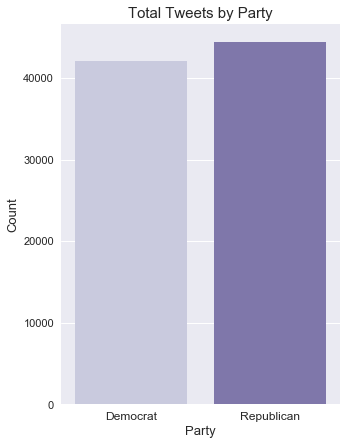

In [90]:
plt.figure(figsize=(5,7))
sns.countplot(x = 'Party', data = df, palette='Purples')
plt.title('Total Tweets by Party', size = 15)
plt.xlabel('Party', size = 13)
plt.ylabel('Count', size = 13)
plt.xticks(size = 12)
plt.yticks(size = 11);

**Common Words by Party**

We'll continue our EDA by looking at the individual words used in the tweets along party lines. To begin, we'll establish a list of stopwords used to filter the texts:

In [91]:
stopwords = stopwords.words('english')
stopwords += ['rt', 'u', 'amp', 'w', 'th']
stopwords += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Next, we'll write a for loop that iterates through the parties' respective tweets and cleans them text by removing special characters, punctuation, stopwords, et cetera. The comments in the below indicate what each line of code is accomplishing:

In [92]:
democrat_list = []

for d in democrat.Tweet:
    
    d = re.sub(r'http\S+', '', d) # For removing links
    d = re.sub("[^a-zA-Z]", " ", d) # For removing all characters except letters
    d = d.lower() # For converting all words to lowercase
    
    d = nlp.word_tokenize(d) # Tokenizing the words in our corpus
    d = [word for word in d if not word in set(stopwords)] #
    
    lemma = nlp.WordNetLemmatizer() 
    d = [lemma.lemmatize(word) for word in d] # For consolidating multiple words of a single form ('running', 'ran' --> 'run')
    d = " ".join(d)
    
    democrat_list.append(d) # Append the words to our 'democrat_list'

In [93]:
republican_list = []

for r in republican.Tweet:
    
    r = re.sub(r'http\S+', '', r)
    r = re.sub("[^a-zA-Z]", " ", r)
    r = r.lower()
    
    r = nlp.word_tokenize(r)
    r = [word for word in r if not word in set(stopwords)]
   
    lemma=nlp.WordNetLemmatizer()
    r = [lemma.lemmatize(word) for word in r]
    r = " ".join(r)
    
    republican_list.append(r)

Let's view our cleaned democrat and republican tweets: 

In [94]:
democrat_list[:5]

['today senate dems vote savetheinternet proud support similar netneutrality legislation house',
 'winterhavensun winter resident alta vista teacher one several recognized repdarrensoto national teacher apprecia',
 'nbclatino repdarrensoto noted hurricane maria left approximately billion damage congress allocated',
 'nalcabpolicy meeting repdarrensoto thanks taking time meet latinoleader ed marucci guzman nalcabpolicy',
 'vegalteno hurricane season start june st puerto rico readiness well pwr puertorico repdarrensoto espaillatny']

In [95]:
republican_list[:5]

['wastefulwednesday today introduced bill would eliminate global climate change initiative gc',
 'today honored heroic men woman law enforcement lost life line duty nati',
 'congressmanraja last week repralphnorman hosted briefing economic benefit solar energy production',
 'tegacaypd chief parker thankful receive recognition repralphnorman delivered mayor davidloneal national police',
 'visited sc highway patrol bring cupcake thank service honor']

In order to get a count of the total number of cleaned words in our corpus by party, we can split the lists of words and replace the commas with spaces:

In [96]:
democrat_tweets = str(democrat_list).split()
republican_tweets = str(republican_list).split()

democrat_tweets = [word.replace("'","") for word in democrat_tweets]
democrat_tweets = [word.replace("[", "") for word in democrat_tweets]
democrat_tweets = [word.replace("]","") for word in democrat_tweets]
democrat_tweets = [word.replace(",", "") for word in democrat_tweets]

republican_tweets = [word.replace("'","") for word in republican_tweets]
republican_tweets = [word.replace("[", "") for word in republican_tweets]
republican_tweets = [word.replace("]","") for word in republican_tweets]
republican_tweets = [word.replace(",", "") for word in republican_tweets]

In [97]:
print("Total words in Democratic tweets:",len(democrat_tweets))
print("Total words in Republican tweets:",len(republican_tweets))

Total words in Democratic tweets: 443138
Total words in Republican tweets: 457293


**Frequency Distribution**

In order to extract the most common words used by republican and democratic representatives, we'll build a frequency distribution that 

In [98]:
#FreqDist records the number of times each words are used. 

fdist_democrat = FreqDist(democrat_tweets)
fdist_republican = FreqDist(republican_tweets)

In [99]:
print('Most common words used by Democrats:')
display(fdist_democrat)

print('-'*100)

print('Most common words used by Republicans:')
display(fdist_republican)

Most common words used by Democrats:


FreqDist({'today': 3850, 'trump': 2502, 'american': 2053, 'year': 1835, 'thank': 1777, 'family': 1694, 'great': 1676, 'student': 1660, 'day': 1571, 'congress': 1518, ...})

----------------------------------------------------------------------------------------------------
Most common words used by Republicans:


FreqDist({'today': 4883, 'tax': 2885, 'great': 2876, 'house': 2382, 'bill': 2379, 'american': 2241, 'thank': 2118, 'year': 1961, 'day': 1887, 'act': 1820, ...})

Now we'll plot the most frequent words by party:

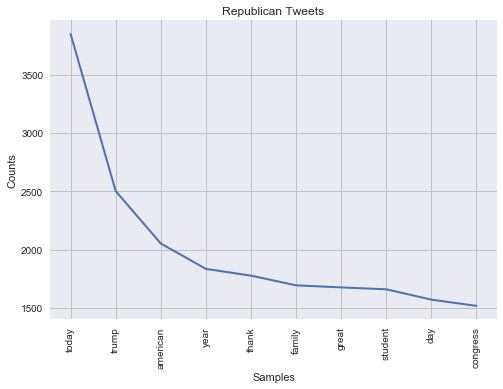

In [100]:
plt.plot(figsize = (15,10))
fdist_democrat.plot(10, title="Republican Tweets")
plt.show()

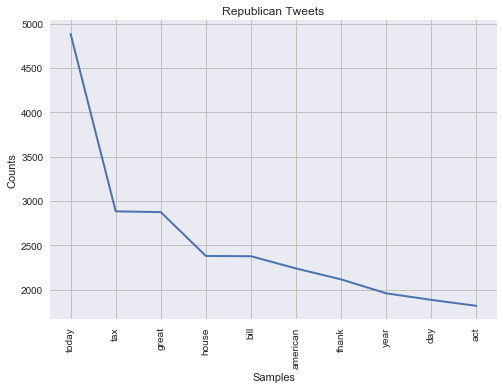

In [101]:
plt.plot(figsize = (15,10))
fdist_republican.plot(10, title="Republican Tweets")
plt.show()

**Relationship Analysis - Using Word2Vec Embeddings**

*** For this part of our EDA analysis, we're going to train an embedding algorithm that will establish relationships between words in our corpus. 

Let's figure our the total number of unique words within our democratic tweet corpus:

In [102]:
dem_vocab = set(word for text in democrat_list for word in text.split(" "))
len(dem_vocab)

35462

In [103]:
dem_tokenized_text = [text.split(" ") for text in democrat_list]
dem_tokenized_text[0]

['today',
 'senate',
 'dems',
 'vote',
 'savetheinternet',
 'proud',
 'support',
 'similar',
 'netneutrality',
 'legislation',
 'house']

In [104]:
dem_embedding = Word2Vec(sentences=dem_tokenized_text, size=30)

In [105]:
dem_embedding.wv.most_similar(positive=['bill'])

[('passed', 0.9199501276016235),
 ('introduced', 0.9155625700950623),
 ('farm', 0.913364052772522),
 ('legislation', 0.9034798741340637),
 ('omnibus', 0.9029474854469299),
 ('amendment', 0.8927937746047974),
 ('hr', 0.8924884796142578),
 ('faa', 0.8905017375946045),
 ('reauthorization', 0.871202826499939),
 ('voted', 0.8689776659011841)]

And the total number of unique words within our repiblican tweet corpus:

In [106]:
rep_vocab = set(word for text in republican_list for word in text.split(" "))
len(rep_vocab)

33086

In [107]:
rep_tokenized_text = [text.split(" ") for text in republican_list]
rep_tokenized_text[0]

['wastefulwednesday',
 'today',
 'introduced',
 'bill',
 'would',
 'eliminate',
 'global',
 'climate',
 'change',
 'initiative',
 'gc']

In [108]:
rep_embedding = Word2Vec(sentences=dem_tokenized_text, size=30)

In [109]:
rep_embedding.wv.most_similar(positive=['bill'])

[('passed', 0.9132592678070068),
 ('introduced', 0.900921106338501),
 ('legislation', 0.9000523090362549),
 ('amendment', 0.8954735398292542),
 ('farm', 0.8948654532432556),
 ('omnibus', 0.8930303454399109),
 ('faa', 0.8713675141334534),
 ('hr', 0.871094286441803),
 ('farmbill', 0.8588005304336548),
 ('spending', 0.8511916399002075)]

**Sentiment Analysis**

In [110]:
democratblob = TextBlob(str(democrat_tweets))
republicanblob = TextBlob(str(republican_tweets))

In [111]:
democratblob.sentiment

Sentiment(polarity=0.16536069955855845, subjectivity=0.4648999095113135)

In [112]:
republicanblob.sentiment

Sentiment(polarity=0.19836825482009132, subjectivity=0.4590716830328091)

**Vocab Size**

In [51]:
all_words = []

for tweet in clean_tweet:
    tokenize_word = word_tokenize(tweet)
    for word in tokenize_word:
        all_words.append(word)

*** removing duplicate words so vocab

In [52]:
vocab_size = set(all_words)
print(len(vocab_size))

53179


------------------------------------------------------------------------------------------------------------------
## Feature Engineering<a id='condition'></a>

[Back to top](#top)

In this section, we're going to prepare our data for running our neural network models. We'll great two sets: one set will be text data that is uncleaned while the other set will be text data that has been cleaned. We'll start by viewing our dataframe once more: 

In [4]:
df = pd.read_csv('ExtractedTweets.csv')
df.head()

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


**Cleaning**

Stopwords for tweet cleaning:

In [5]:
stopwords = stopwords.words('english')
stopwords += ['rt', 'u', 'amp', 'w', 'th']
stopwords += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

*** Alternative cleaning from function above:

In [6]:
clean_tweet = []

for w in df.Tweet:
    
    w = re.sub(r'http\S+', '', w) #remove links
    w = re.sub("[^a-zA-Z]", " ", w) #remove all characters except letters
    w = w.lower() #convert all words to lowercase
    
    w = nlp.word_tokenize(w) #split sentences into word
    w = [word for word in w if not word in set(stopwords)] #add to stopwords list if unnecessary words.
    
    lemma = nlp.WordNetLemmatizer() 
    w = [lemma.lemmatize(word) for word in w] #identify the correct form of the word in the dictionary
    
    w = " ".join(w)
    
    clean_tweet.append(w) #append words to list

Let's save our cleaned text data to a json file for easy access going forward:

In [1]:
df["clean_tweet"] = clean_tweet

df.to_json("cleaned_tweet_data.json")

NameError: name 'clean_tweet' is not defined

Let's call back our saved cleaned data:

In [3]:
df = pd.read_json("cleaned_tweet_data.json")
df.head()

,Party,Handle,Tweet,clean_tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",today senate dems vote savetheinternet proud s...
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,winterhavensun winter resident alta vista teac...
10,Democrat,RepDarrenSoto,RT @AllSaints_FL: Zhihan (John)'s art received...,allsaints fl zhihan john art received award ye...
100,Democrat,RepDarrenSoto,Thanks to @FL_WildCorridor @CarltonWard @JoeGu...,thanks fl wildcorridor carltonward joeguthrie ...
1000,Democrat,RepBarragan,Very cool. Congrats Luz on breaking a barrier ...,cool congrats luz breaking barrier baseball li...


Let's compare the original tweets to the now cleaned text set: 

In [4]:
display(df['Tweet'][0])
display(df['Tweet'][1])
display(df['Tweet'][2])
display(df['Tweet'][3])
display(df['Tweet'][4])

'Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House… https://t.co/n3tggDLU1L'

'RT @WinterHavenSun: Winter Haven resident / Alta Vista teacher is one of several recognized by @RepDarrenSoto for National Teacher Apprecia…'

'RT @NBCLatino: .@RepDarrenSoto noted that Hurricane Maria has left approximately $90 billion in damages. \n\nCongress has allocated about $18…'

'RT @NALCABPolicy: Meeting with @RepDarrenSoto . Thanks for taking the time to meet with @LatinoLeader ED Marucci Guzman. #NALCABPolicy2018.…'

'RT @Vegalteno: Hurricane season starts on June 1st; Puerto Rico’s readiness...well 🤦🏼\u200d♂️😡😩@Pwr4PuertoRico @RepDarrenSoto @EspaillatNY'

In [5]:
clean_tweet = df.clean_tweet

display(clean_tweet[0])
display(clean_tweet[1])
display(clean_tweet[2])
display(clean_tweet[3])
display(clean_tweet[4])

'today senate dems vote savetheinternet proud support similar netneutrality legislation house'

'winterhavensun winter resident alta vista teacher one several recognized repdarrensoto national teacher apprecia'

'nbclatino repdarrensoto noted hurricane maria left approximately billion damage congress allocated'

'nalcabpolicy meeting repdarrensoto thanks taking time meet latinoleader ed marucci guzman nalcabpolicy'

'vegalteno hurricane season start june st puerto rico readiness well pwr puertorico repdarrensoto espaillatny'

**Convert Labels to Integers**

Now that our text data is cleaned, we'll need to convert our labels into digits so we can run them through our models. For our data, we'll make Democrat tweets a 1 and republican tweets a 0:

In [8]:
labels = [1 if p == 'Democrat' else 0 for p in df.Party]
labels = np.array(labels)
labels.shape

(86460,)

**Tokenize Text**

In [9]:
tokenizer = text.Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(list(df["clean_tweet"]))

list_tokenized_train = tokenizer.texts_to_sequences(df["clean_tweet"])

**Padding**

In [10]:
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=40, padding='post')
display(X_t[1])
display(X_t.shape)

array([15041,  1716,   402, 15042,  4455,   241,    23,   818,  1121,
        1555,    39,   241, 15043,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

(86460, 40)

In [11]:
X_t[1]

array([15041,  1716,   402, 15042,  4455,   241,    23,   818,  1121,
        1555,    39,   241, 15043,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

**Train Test Split**

We'll split our data using the train_test_split method from sklearn with 20% as the test set and 80% as the train set:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_t, labels, test_size=0.20, random_state=42)

In [13]:
X_train.shape

(69168, 40)

In [14]:
y_train.shape

(69168,)

------------------------------------------------------------------------------------------------------------------
## Modeling <a id='model'></a>

[Back to top](#top)

**LSTM Model One**

We'll start by compiling our LSTM model:


In [21]:
lstm_model = Sequential()

lstm_model.add(Embedding(20000, 128, input_length=40)) # embedding size of 20000 so we use only the 20000 most used words in our corpus

lstm_model.add(LSTM(50, return_sequences=True))

lstm_model.add(GlobalMaxPool1D()) # so the model uses a maxpool operation across all weights in the recurrent layer

lstm_model.add(Dropout(0.5)) # layer set to .5 to limit overfitting

lstm_model.add(Dense(50, activation='relu')) # layer of 50 with activation set to relu

lstm_model.add(Dropout(0.5)) 

lstm_model.add(Dense(2, activation='sigmoid')) # output layer activation set to sigmoid for binary classification

Let's compile our model: 

In [22]:
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

And reviwe the overall architecture: 

In [23]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 128)           2560000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 40, 50)            35800     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 102       
Total para

In [24]:
history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 55334 samples, validate on 13834 samples
Epoch 1/6
55334/55334 [==============================] - 34s 620us/step - loss: 0.5453 - acc: 0.7114 - val_loss: 0.4382 - val_acc: 0.7848
Epoch 2/6
55334/55334 [==============================] - 33s 603us/step - loss: 0.3749 - acc: 0.8297 - val_loss: 0.4204 - val_acc: 0.7949
Epoch 3/6
55334/55334 [==============================] - 43s 781us/step - loss: 0.3033 - acc: 0.8636 - val_loss: 0.4587 - val_acc: 0.7945
Epoch 4/6
55334/55334 [==============================] - 34s 618us/step - loss: 0.2533 - acc: 0.8830 - val_loss: 0.5180 - val_acc: 0.7890
Epoch 5/6
55334/55334 [==============================] - 36s 649us/step - loss: 0.2169 - acc: 0.8971 - val_loss: 0.5721 - val_acc: 0.7877
Epoch 6/6
55334/55334 [==============================] - 33s 593us/step - loss: 0.1883 - acc: 0.9108 - val_loss: 0.6935 - val_acc: 0.7865


In [26]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

17292/17292 [==============================] - 3s 170us/step


In [27]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.7020312369131749
Test Accuracy: 0.7882257691417996


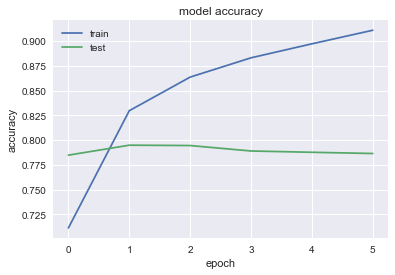

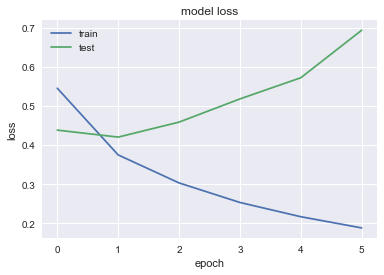

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

**LSTM Model Two**

**GRU Model**

In [ ]:
gru_model = Sequential()
gru_model.add(Embedding(20000, 128))
gru_model.add(GRU(50, return_sequences=True))
gru_model.add(GlobalMaxPool1D())
gru_model.add(Dropout(0.5))
gru_model.add(Dense(50, activation='relu'))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(2, activation='softmax'))

In [ ]:
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
gru_model.summary()

In [ ]:
gru_model.fit(X_t, labels, epochs=2, batch_size=32, validation_split=0.1)

------------------------------------------------------------------------------------------------------------------

## Cost Benefit Analysis Result <a id='costbenefitanalysis'></a>

[Back to top](#top)

------------------------------------------------------------------------------------------------------------------
## Conclusion <a id='conclusion'></a>

[Back to top](#top)

**Question:** xx

**Answer:** xx

------------------------------------------------------------------------------------------------------------------
## Recommendations <a id='recommendation'></a>

[Back to top](#top)

------------------------------------------------------------------------------------------------------------------
## Future Work <a id='futurework'></a>

[Back to top](#top)